In [248]:
import cv2
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import torch
%matplotlib inline

In [249]:
import warnings
warnings.filterwarnings('ignore')

In [250]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_train = 'drive/MyDrive/Tactil/train'
path_test = 'drive/MyDrive/Tactil/test'

In [ ]:
def show_images(path, title):
  h, w = 2, 4
  fig, ax = plt.subplots(h, w, figsize=(20, 10))

  for idx, file_name in enumerate(os.listdir(os.path.join(*path))):

    if idx == 8:
      break
        
    path.append(file_name)
    
    if Path(os.path.join(*path)).suffix == '.jpg':
        image = cv2.imread(os.path.join(*path))
        image = image[:, :, ::-1]
        
        plt.subplot(h, w, idx+1)
        plt.title(title)
        plt.imshow(cv2.imread(os.path.join(*path))[:, :, ::-1])

    path.pop()

  plt.show()

Посмотрим на исходные изображения

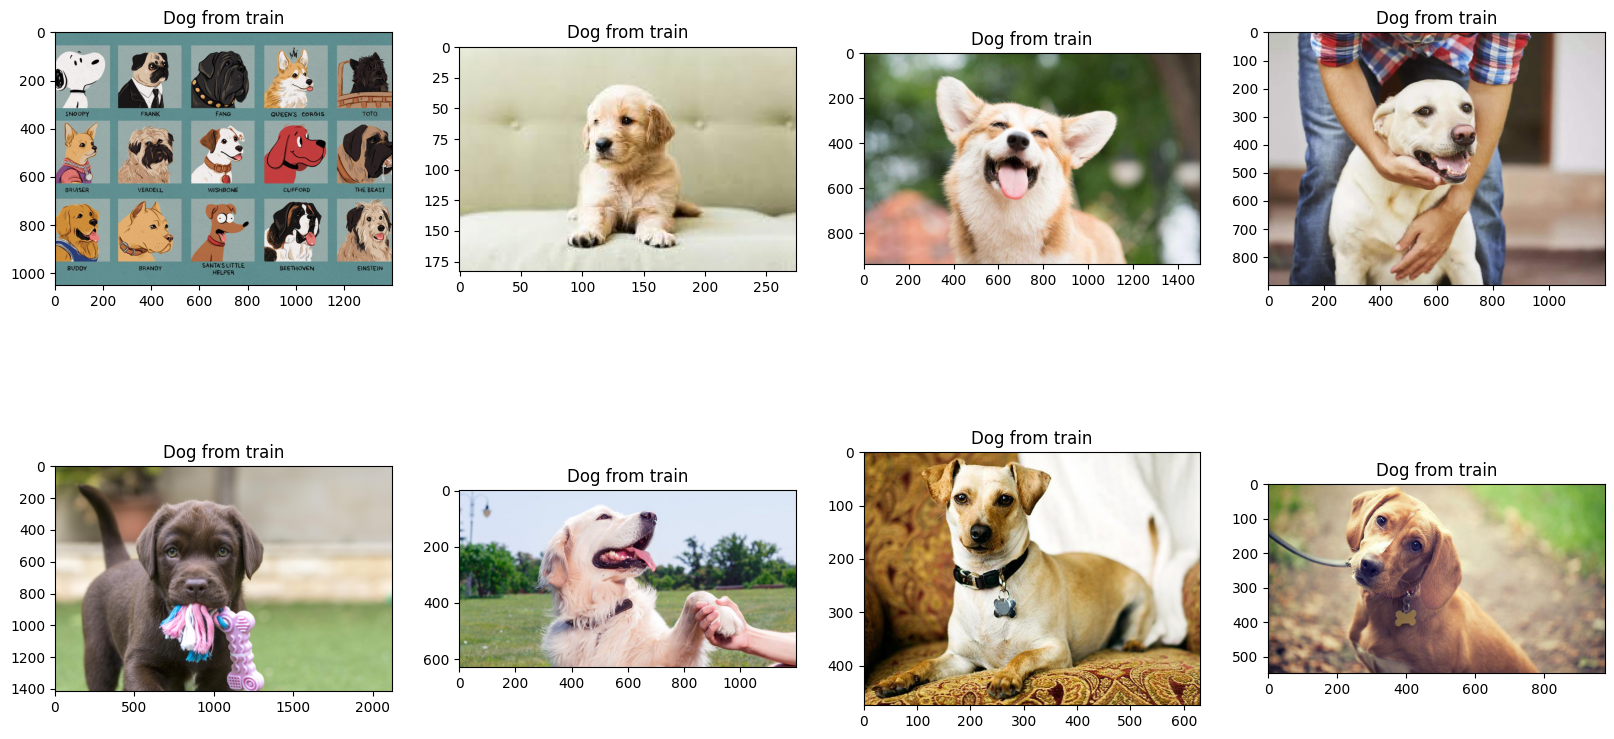

In [251]:
show_images([path_train, 'dogs'], 'Dog from train')

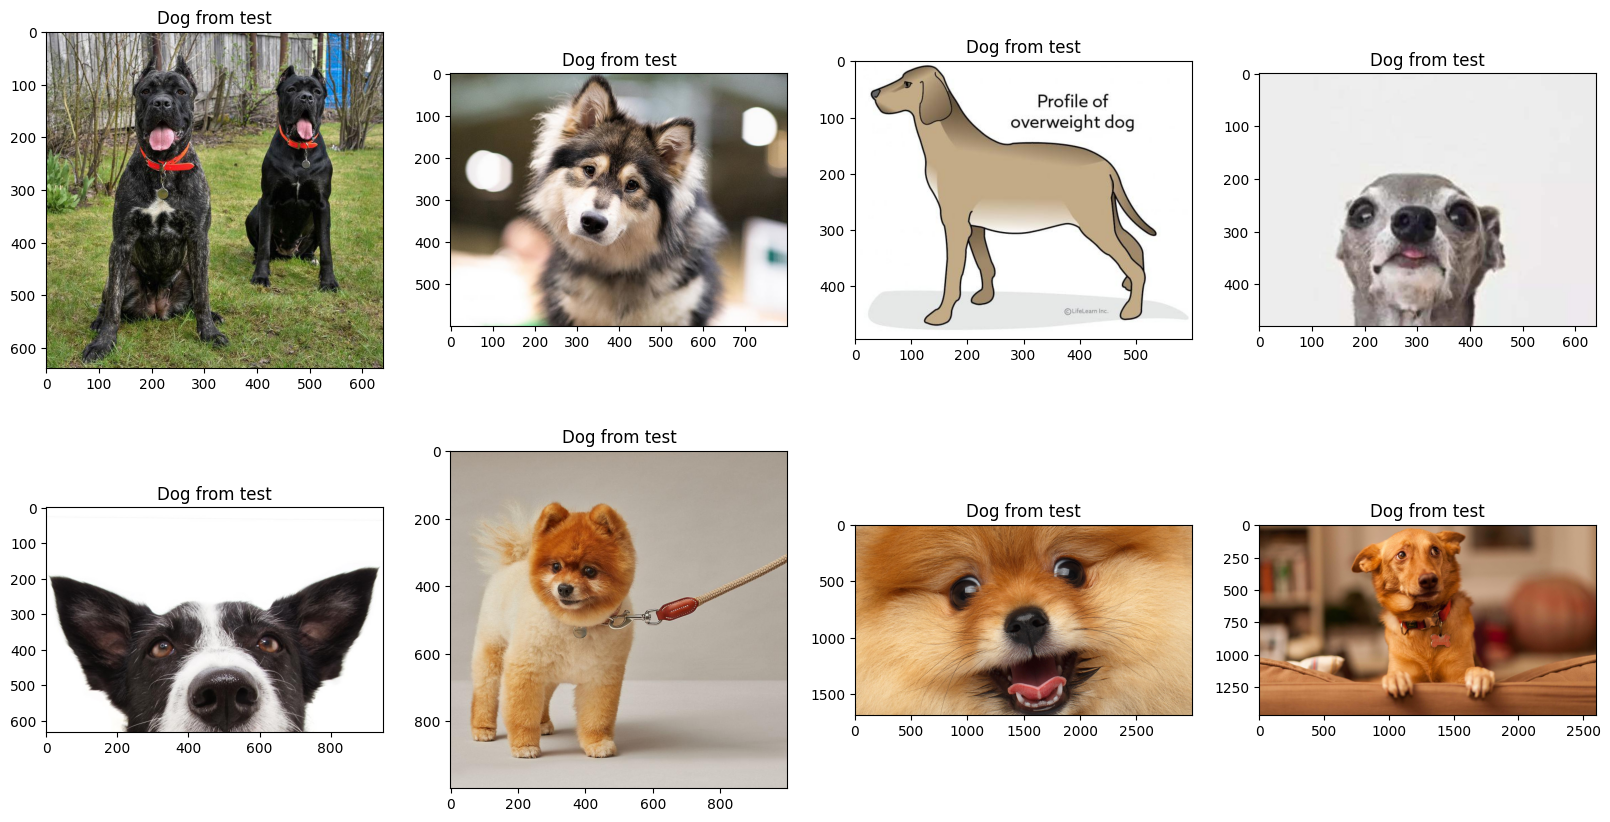

In [ ]:
show_images([path_test, 'dogs'], 'Dog from test')

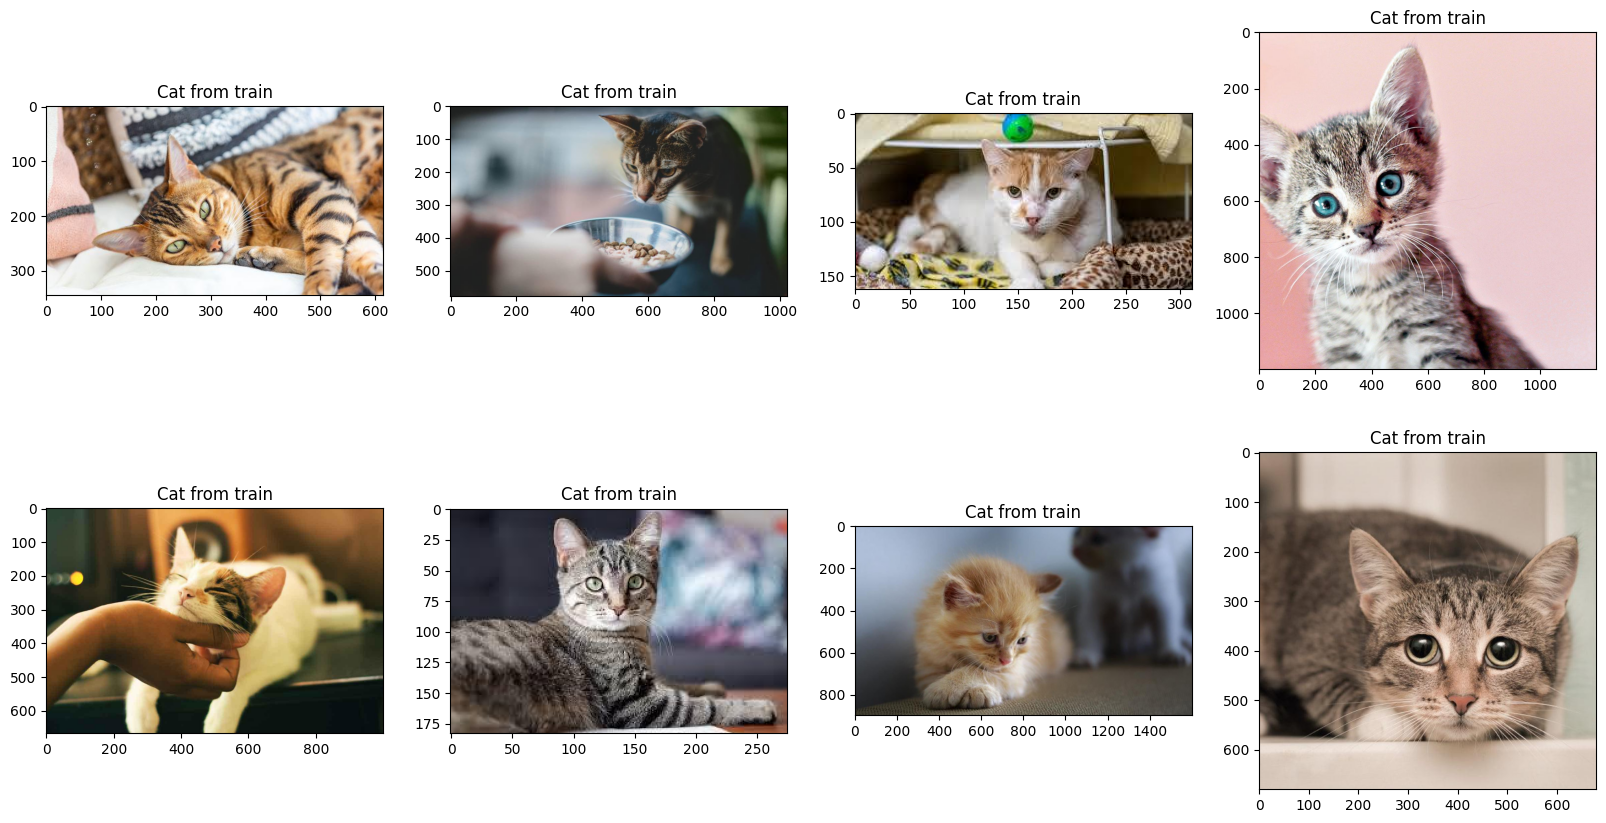

In [ ]:
show_images([path_train, 'cats'], 'Cat from train')

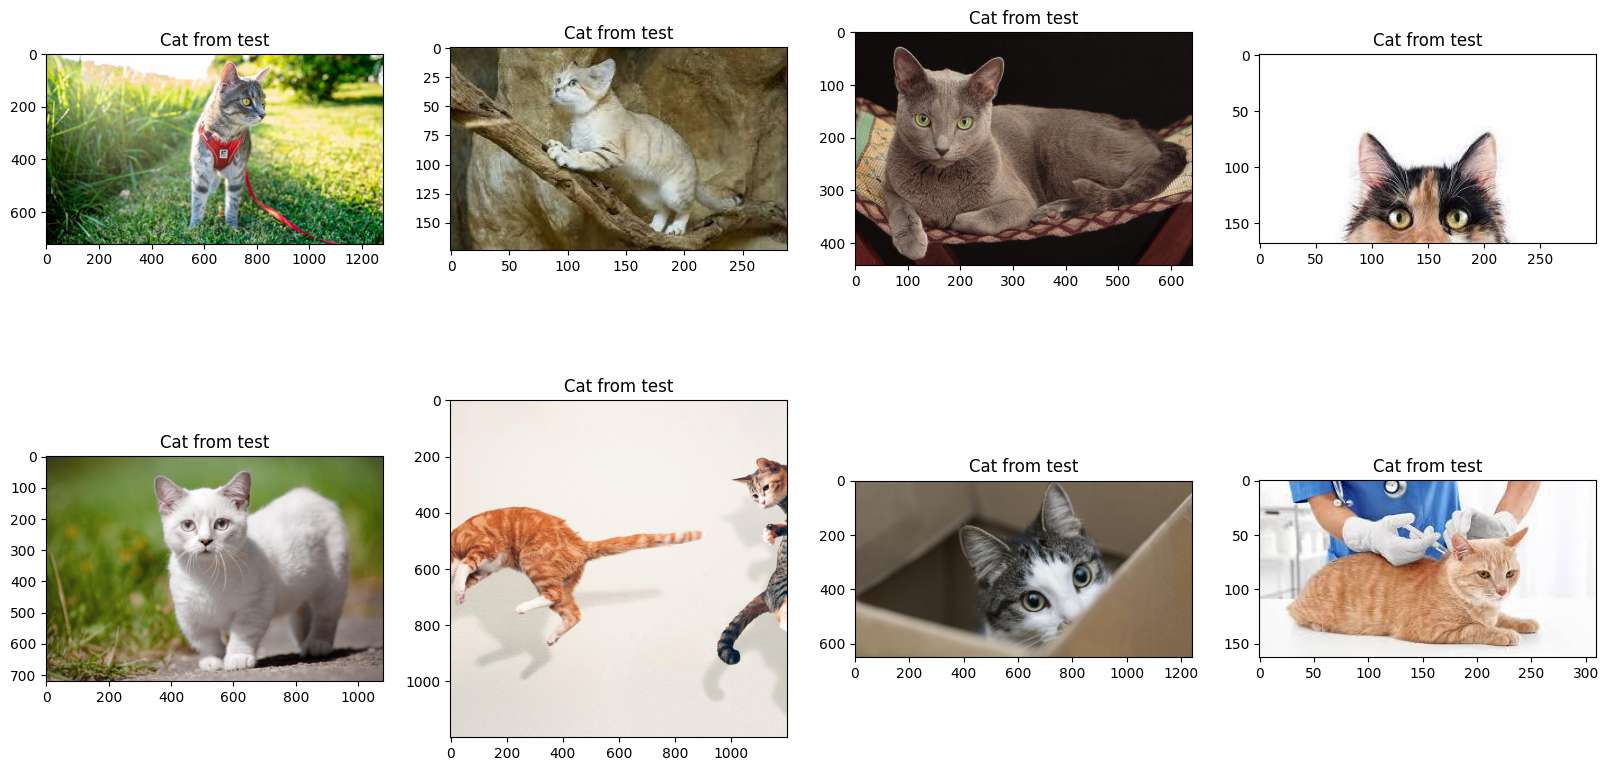

In [ ]:
show_images([path_test, 'cats'], 'Cat from test')

Посмотрим на следующие параметры наших картинок:

1) средние размеры и кол-во каналов (нужно для выбора подходящей предобученной модели)

2) Посчитаем поканальные mean и std для нормирования картинок

In [ ]:
from pathlib import Path

In [ ]:
def see_info(path):
  means = []
  stds = []
  shapes = []

  path_dogs = [path] + ['dogs']
  path_cats = [path] + ['cats']

  for file_name in os.listdir(os.path.join(*path_dogs)):
      
      path_dogs.append(file_name)
      
      if Path(os.path.join(*path_dogs)).suffix == '.jpg':
          image = cv2.imread(os.path.join(*path_dogs))
          image = image[:, :, ::-1]
          
          means.append(image.mean(axis =(0,1)))
          stds.append(image.std(axis =(0,1)))
          shapes.append(image.shape)

      path_dogs.pop()

  ######################################################

  for file_name in os.listdir(os.path.join(*path_cats)):
      
      path_cats.append(file_name)
      
      if Path(os.path.join(*path_cats)).suffix == '.jpg':
          image = cv2.imread(os.path.join(*path_cats))
          image = image[:, :, ::-1]
          
          means.append(image.mean(axis =(0,1)))
          stds.append(image.std(axis =(0,1)))
          shapes.append(image.shape)

      path_cats.pop()

  return {
          'channel mean' : np.array(means).mean(axis=0),
          'channel std' : np.array(stds).mean(axis=0),
          'shapes mean' : np.array(shapes).mean(axis=0),
          'min channels count' : np.array(shapes)[:,2].min(axis=0)
          }

  

In [ ]:
information_dict = see_info('drive/MyDrive/Tactil/train')

information_dict

{'channel mean': array([149.8103841 , 142.56762436, 127.36842784]),
 'channel std': array([58.04222853, 57.95543509, 60.39705553]),
 'shapes mean': array([657.1956912 , 952.46499102,   3.        ]),
 'min channels count': 3}

Сделаем следующие выводы:

1) Картинки имеют большую размерность => имеет выбрать предобученную модель, для которой не придется сильно сжимать картинку (efficientnet_b7 имеет входы 600x600 => он хорошо подойтет для данной задачи)

2) Все картинки имеют по 3 канала => нам меньше хлопот :)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tr

In [ ]:
channel_mean = np.array(means).mean(axis=0)
channel_std = np.array(stds).mean(axis=0)

print(channel_mean / 255, channel_std/ 255)

[0.5874917  0.55908872 0.49948403] [0.22761658 0.22727622 0.2368512 ]


Добавим image_prepare в наш датасет. 

Normalize отнормирует наши картинки

RandomHorizontalFlip и RandomCrop будут использованы для аугментации данных, т.е. для создания новых вариантов изображений на основе существующих, что может помочь улучшить обобщающую способность сети.


In [ ]:
from sklearn.preprocessing import minmax_scale

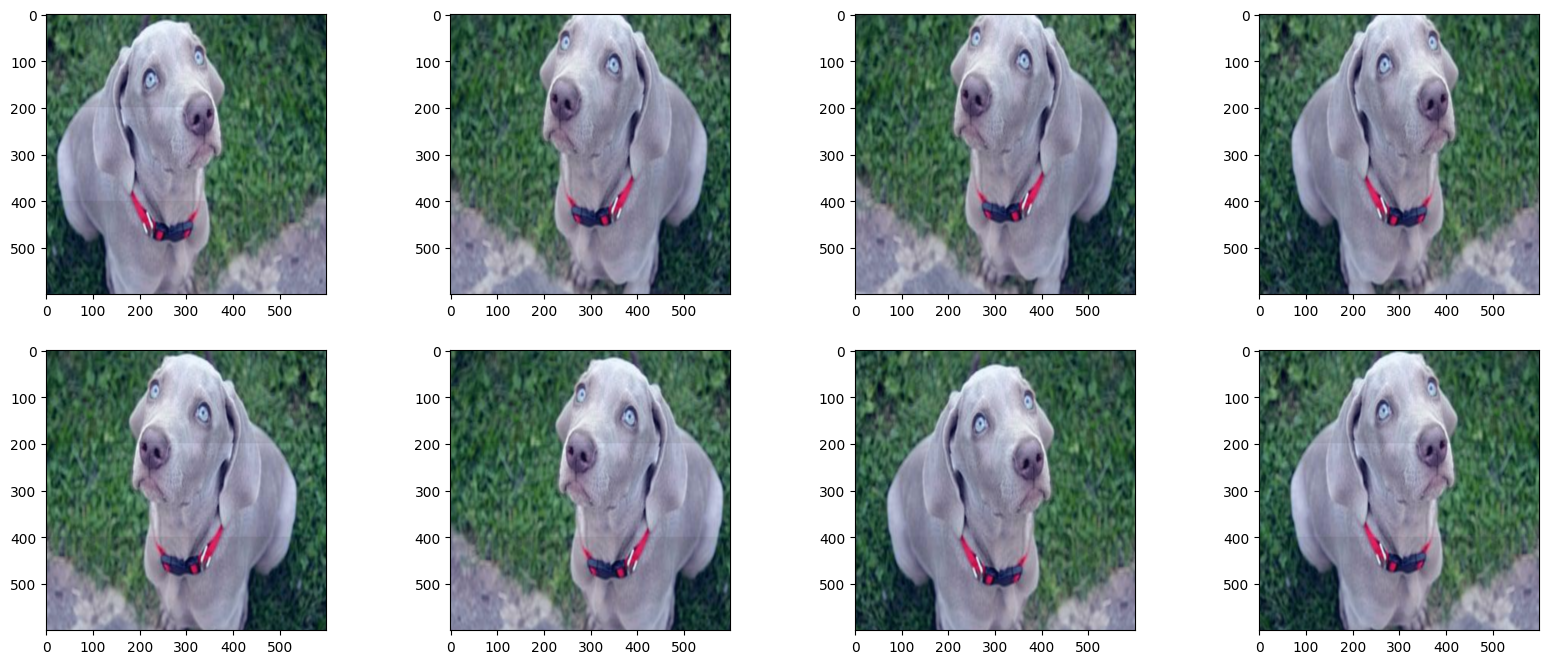

In [ ]:
image_prepare = tr.Compose([
    tr.ToPILImage(),
    tr.ToTensor(),
    tr.RandomHorizontalFlip(),
    tr.Resize((660, 660)),
    tr.RandomCrop((600, 600)),
    tr.Normalize(channel_mean / 255, channel_std / 255)
])

image = cv2.imread(os.path.join('drive/MyDrive/Tactil', 'train', 'dogs', "dog_3.jpg"))
image = image[:, :, ::-1]

def de_normalize(img):
    return minmax_scale(
        (img.reshape(3, -1) + channel_mean[:, None]) * channel_std[:, None],
        axis=1,
    ).reshape(*img.shape)


fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    transformed_image = image_prepare(image).numpy().transpose(1, 2, 0)
    plt.imshow(de_normalize(transformed_image))
plt.show()

In [ ]:
import random

In [252]:
#!c1.8

class ImageDataset(Dataset):
    """
        images_path ~ путь к папке с изображениями
    """
    def __init__(self, images_path):
        super(ImageDataset).__init__()
        
        self.items = []
        
        path_cats = images_path + '/' + 'cats'
        path_dogs = images_path + '/' + 'dogs'
        
        for file_name in os.listdir(path_cats):
    
            path = path_cats + '/' + file_name

            if Path(path).suffix == '.jpg':
                image = cv2.imread(path)
                image = image[:, :, ::-1]
                self.items.append((image, 0))
        
        for file_name in os.listdir(path_dogs):
    
            path = path_dogs + '/' + file_name

            if Path(path).suffix == '.jpg':
                image = cv2.imread(path)
                image = image[:, :, ::-1]
                self.items.append((image, 1))

        random.shuffle(self.items)    
                

    def __getitem__(self, index):
        
        image, label = self.items[index]
        image = image_prepare(image)
        
        return torch.Tensor(image), label
    
    def __len__(self):
        return len(self.items)

In [253]:
#!g1.1
ds_train = ImageDataset(path_train)
ds_test = ImageDataset(path_test)

In [254]:
batch_size = 12

dataloader_train = DataLoader(
    dataset=ds_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

dataloader_val = DataLoader(
    dataset=ds_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)

In [255]:
from collections import OrderedDict
from torchvision.models import efficientnet_b7
from torch import nn

Займемся созданием нашей нейронной сети. 

За основы будет взят efficientnet_b7. У efficientnet_b7 мы изменим последние слои (вместо 2560 выходов мы должны иметь всего 2)

In [256]:
class fc_block(nn.Module):
    def __init__(self, inputs, outputs):
        super(fc_block, self).__init__()
            
        self.fc = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(inputs, outputs)),
            ('bnorm1', nn.BatchNorm1d(outputs)),
            ('act1', nn.ReLU()),
            
            ('fc2', nn.Linear(outputs, outputs)),
            ('bnorm2', nn.BatchNorm1d(outputs)),
            ('ac2', nn.ReLU()),
        ]))
        
    def forward(self, x):
        return self.fc(x)

In [257]:
class img_fe_class(nn.Module):
    def __init__(self, dropout_p = 0.4):
        super(img_fe_class, self).__init__()

        eff_net = efficientnet_b7(pretrained=True)
        
        for param in eff_net.parameters():
            param.requires_grad = False
            
        inputs = eff_net.classifier[1].in_features
            
        eff_net.classifier = nn.Sequential(OrderedDict([
            ('fc_block1', fc_block(inputs, 256)),
            ('fc_block2', fc_block(256, 64)),
            ('fc_block3', fc_block(64, 16)),
            ('fc_out', nn.Linear(16, 2))
        ]))
        
        self.img_fe = eff_net
        
    def forward(self, imgs):
        return self.img_fe(imgs)

In [258]:
img_batch, label_batch = next(iter(dataloader_train))

model = img_fe_class()

res = model(img_batch)

assert res.shape[0] == np.sum(img_batch.shape[0])
assert res.shape[1] == 2

print(res.shape)

torch.Size([12, 2])


In [259]:
#model_scripted = torch.jit.script(model) # Export to TorchScript
#model_scripted.save('model_scripted_resnet101.pt')

In [260]:
import IPython
from math import ceil

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = model.to(device)

def train_loop(model, dataloader, loss_fn, optimizer, step=0.05, history_loss=None, history_acc=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)

    size = len(dataloader.dataset) 
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1
    
    train_acc, train_loss = [], []
    percentage = 0
    
    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        X, y = X.to(device), y.to(device)

        # evaluate
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        # print info
        if batch / batches > percentage or batch == batches: 
            out.update(f'[{int(percentage * size)}/{size}] Loss: {loss:>8f}')
            percentage += step
        
    if history_loss is not None:
        history_loss.append(np.mean(train_loss))
    if history_acc is not None:
        history_acc.append(np.mean(train_acc))

    return {'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc)}

def test_loop(model, dataloader, loss_fn, history_loss=None, history_acc=None):

    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size)

    val_loss, val_acc = [], []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= batches
    correct /= size
    
    print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation loss: {test_loss:>8f} \n")

    if history_loss is not None:
        history_loss.append(np.mean(val_loss))
    if history_acc is not None:
        history_acc.append(np.mean(val_acc))
    
    return {'val_loss': np.mean(val_loss), 'val_acc': np.mean(val_acc)}


In [261]:
device

device(type='cuda', index=0)

In [262]:
def plot_learning_process(train_loss, train_acc, val_loss, val_acc):
    
    fig = plt.figure(figsize=(12, 4))
    
    ax1 = plt.subplot(121)
    ax1.set_title('loss by epoch')
    ax1.plot(np.arange(0, len(train_loss)) + 0.5, train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss function')

    ax2 = plt.subplot(122)
    ax2.set_title('accuracy by epoch')
    ax2.plot(np.arange(0, len(train_acc)) + 0.5, train_acc, label='train')
    ax2.plot(np.arange(0, len(val_acc)) + 1, val_acc, label='val')
    ax2.legend()
    ax2.grid()
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    
    fig.tight_layout()
    plt.show()

В качестве функции потерь используем cross_entropy

В качетсве метрики используем обычную accuracy, т к у нас классы полностью равноценны и сбалансированы.

In [263]:
loss_fn = torch.nn.functional.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 18

train_loss, train_acc = [], []
val_loss, val_acc = [], []

model = model.to(device)
    
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(model, dataloader_train, loss_fn, optimizer)
    test_loop(model, dataloader_val, loss_fn)
# <----- your code here ----->

Epoch 1
-------------------------------


'[529/557] Loss: 0.562851'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 78.6%, Validation loss: 0.548624 

Epoch 2
-------------------------------


'[529/557] Loss: 0.540578'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 82.1%, Validation loss: 0.495166 

Epoch 3
-------------------------------


'[529/557] Loss: 0.546212'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 91.4%, Validation loss: 0.444288 

Epoch 4
-------------------------------


'[529/557] Loss: 0.434148'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 89.3%, Validation loss: 0.421709 

Epoch 5
-------------------------------


'[529/557] Loss: 0.354645'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 90.0%, Validation loss: 0.396663 

Epoch 6
-------------------------------


'[529/557] Loss: 0.528642'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 95.7%, Validation loss: 0.367989 

Epoch 7
-------------------------------


'[529/557] Loss: 0.317819'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 93.6%, Validation loss: 0.348331 

Epoch 8
-------------------------------


'[529/557] Loss: 0.318842'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 93.6%, Validation loss: 0.333918 

Epoch 9
-------------------------------


'[529/557] Loss: 0.291315'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 95.0%, Validation loss: 0.316844 

Epoch 10
-------------------------------


'[529/557] Loss: 0.242936'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 96.4%, Validation loss: 0.302770 

Epoch 11
-------------------------------


'[529/557] Loss: 0.268300'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 92.1%, Validation loss: 0.308712 

Epoch 12
-------------------------------


'[529/557] Loss: 0.229726'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 91.4%, Validation loss: 0.275138 

Epoch 13
-------------------------------


'[529/557] Loss: 0.217002'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 95.0%, Validation loss: 0.267399 

Epoch 14
-------------------------------


'[529/557] Loss: 0.213879'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 92.1%, Validation loss: 0.268964 

Epoch 15
-------------------------------


'[529/557] Loss: 0.159265'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 94.3%, Validation loss: 0.248435 

Epoch 16
-------------------------------


'[529/557] Loss: 0.213917'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 95.0%, Validation loss: 0.238145 

Epoch 17
-------------------------------


'[529/557] Loss: 0.319534'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 92.9%, Validation loss: 0.239032 

Epoch 18
-------------------------------


'[529/557] Loss: 0.163231'

Batch #:   0%|          | 0/46 [00:00<?, ?it/s]

Validation accuracy: 93.6%, Validation loss: 0.243032 



In [264]:
def find_mistakes(model, dataset):
    model.eval()
    
    fig, ax = plt.subplots(2, 4, figsize=(20, 8))
    i = 1

    for image, label in dataset:
      if i == 9:
        break

      pred = model(image[None, :].to(device))
      
      if torch.argmax(pred).item() != label:
        #print(torch.argmax(pred).item())

        transformed_image = image.numpy().transpose(1, 2, 0)

        plt.subplot(2, 4, i)
        plt.imshow(de_normalize(transformed_image))
        i += 1

Посмотрим на картинки, в которых мы ошибаемся

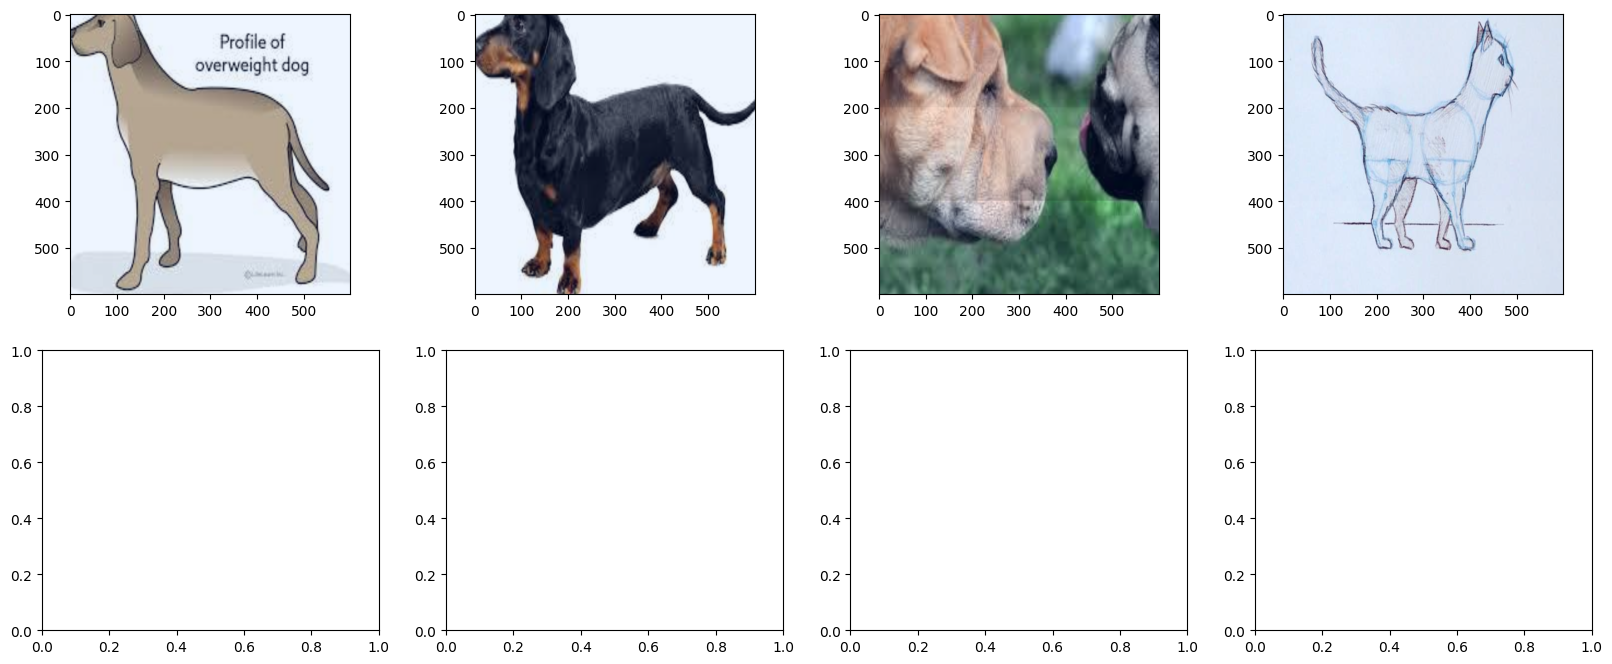

In [265]:
find_mistakes(model, ds_test)

In [266]:
def find_correct_answers(model, dataset):
    model.eval()
    
    fig, ax = plt.subplots(2, 4, figsize=(20, 8))
    i = 1

    for image, label in dataset:
      if i == 9:
        break

      pred = model(image[None, :].to(device))
      
      if torch.argmax(pred).item() == label:
        #print(torch.argmax(pred).item())

        transformed_image = image.numpy().transpose(1, 2, 0)

        plt.subplot(2, 4, i)
        plt.imshow(de_normalize(transformed_image))
        i += 1

Сравним с теми, на которые мы даем правильные ответы

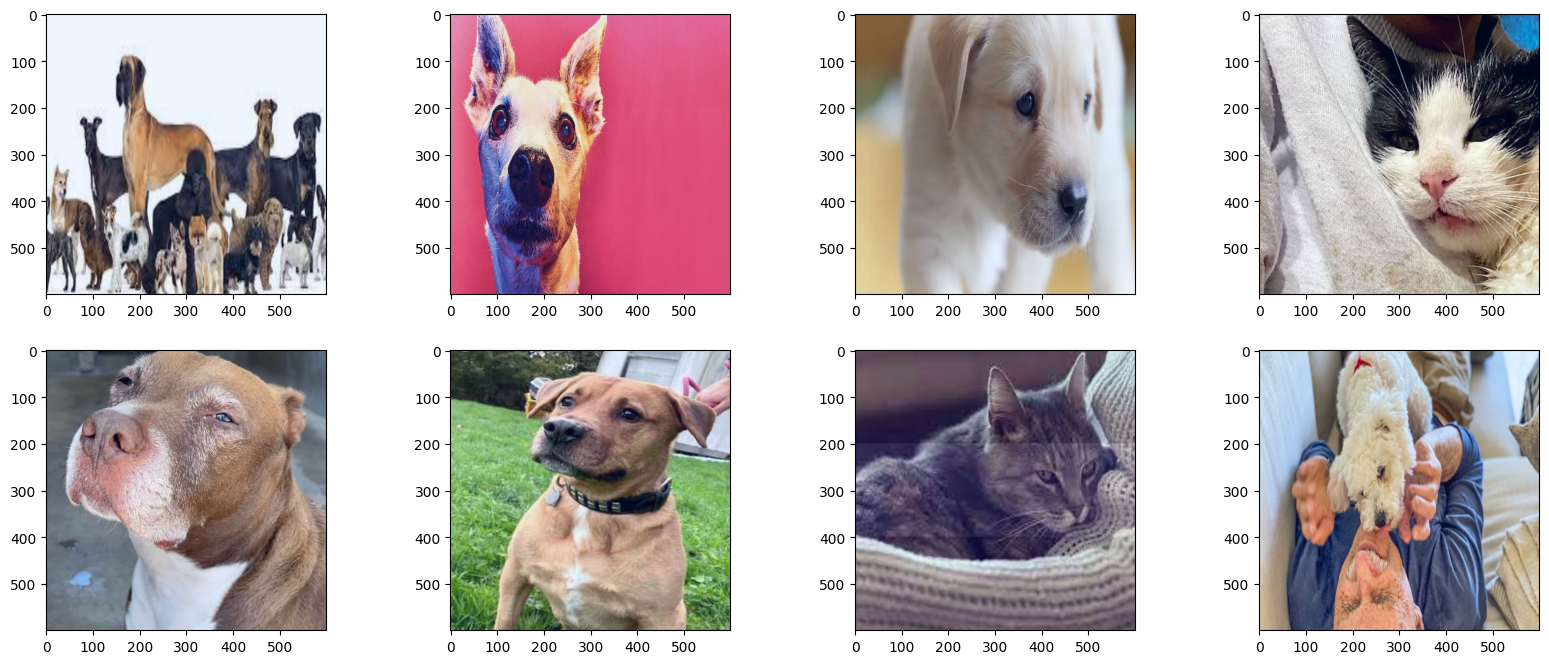

In [ ]:
find_correct_answers(model, ds_test)

Таким образом мы получили нейронную сеть, способную хорошо решать поставленную задачу